In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34686041416_e50c8028f9_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/8719032054_9a3ce4f0ff.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9472854850_fc9e1db673.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/31530587330_ba31bd196e_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9293460423_7fbb1e3c32_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9939430464_5f5861ebab.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2535769822_513be6bbe9.jpg
/kaggle/input/flowers-recognition/flowers/dande

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
import cv2
import os
import random
import tensorflow as tf

# Loading the Dataset

In [4]:
labels = ['dandelion','daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
data = get_data("/kaggle/input/flowers-recognition/flowers")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


# Data Visualization and Preprocessing

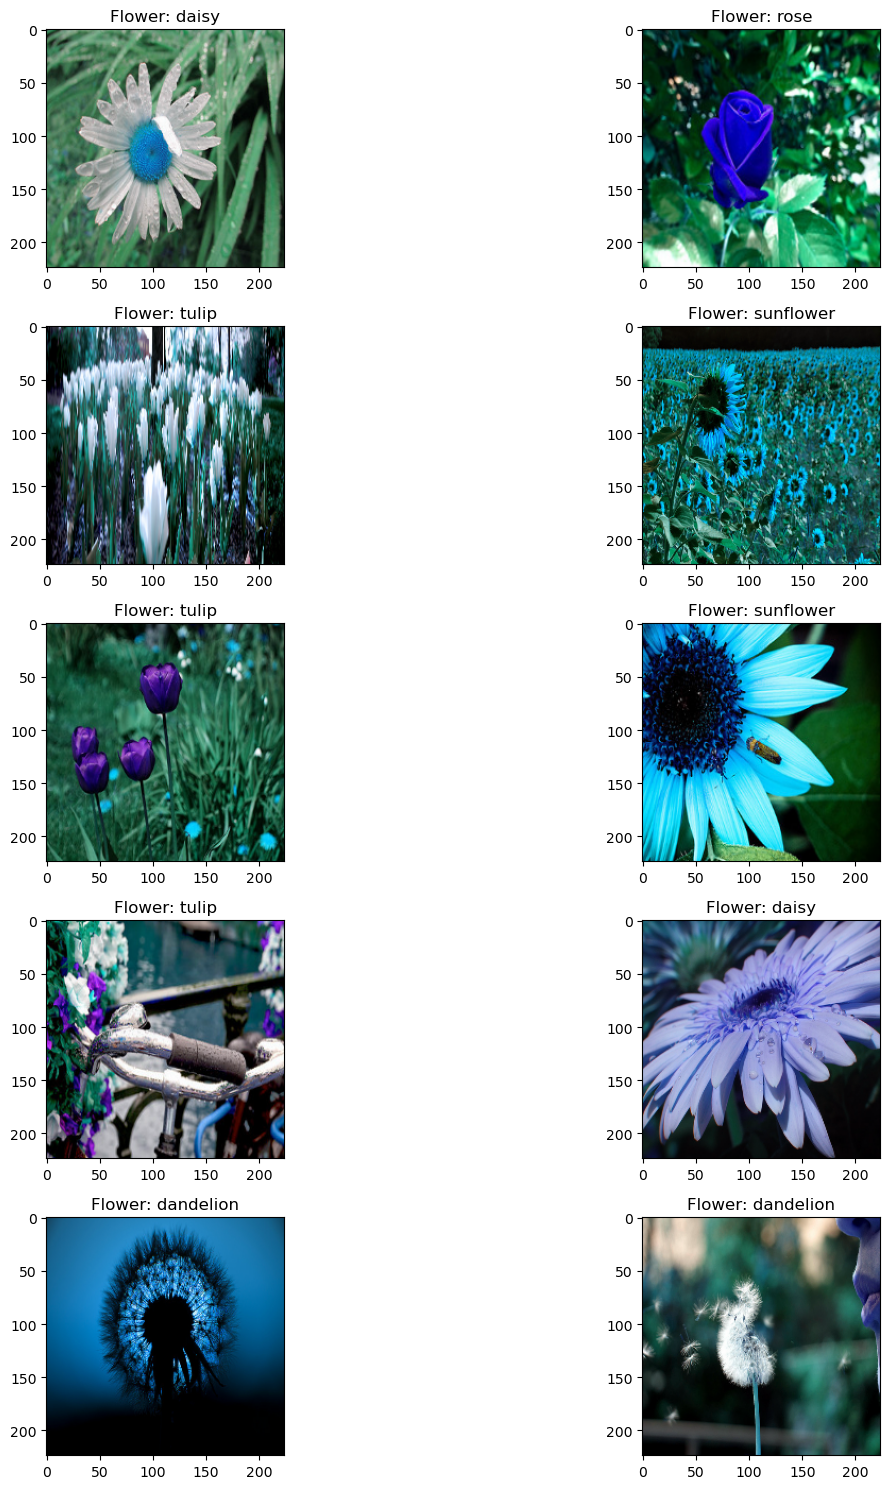

In [6]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [7]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [8]:
# Normalize the data
x = np.array(x) / 255

In [9]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

# CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE

In [12]:
del x,y,data

In [13]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Training The Model

In [14]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [15]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [16]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 12 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/12
54/54 [==============================] - 32s 372ms/step - loss: 0.8863 - accuracy: 0.6696 - val_loss: 0.5046 - val_accuracy: 0.8137 - lr: 0.0010
Epoch 2/12
54/54 [==============================] - 10s 192ms/step - loss: 0.4184 - accuracy: 0.8439 - val_loss: 0.4075 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 3/12
54/54 [==============================] - 10s 192ms/step - loss: 0.2566 - accuracy: 0.9070 - val_loss: 0.4088 - val_accuracy: 0.8507 - lr: 0.0010
Epoch 4/12
54/54 [==============================] - 11s 204ms/step - loss: 0.1884 - accuracy: 0.9308 - val_loss: 0.3997 - val_accuracy: 0.8808 - lr: 0.0010
Epoch 5/12
54/54 [==============================] - 10s 192ms/step - loss: 0.1066 - accuracy: 0.9708 - val_loss: 0.4274 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 6/12
54/54 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9858
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
54/54 [==============================] - 10s 192ms

In [17]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

27/27 [==============================] - 2s 80ms/step - loss: 0.5282 - accuracy: 0.8831
Loss of the model is -  0.5282251834869385
27/27 [==============================] - 2s 78ms/step - loss: 0.5282 - accuracy: 0.8831
Accuracy of the model is -  88.31018805503845 %


# Analysis after Model Training

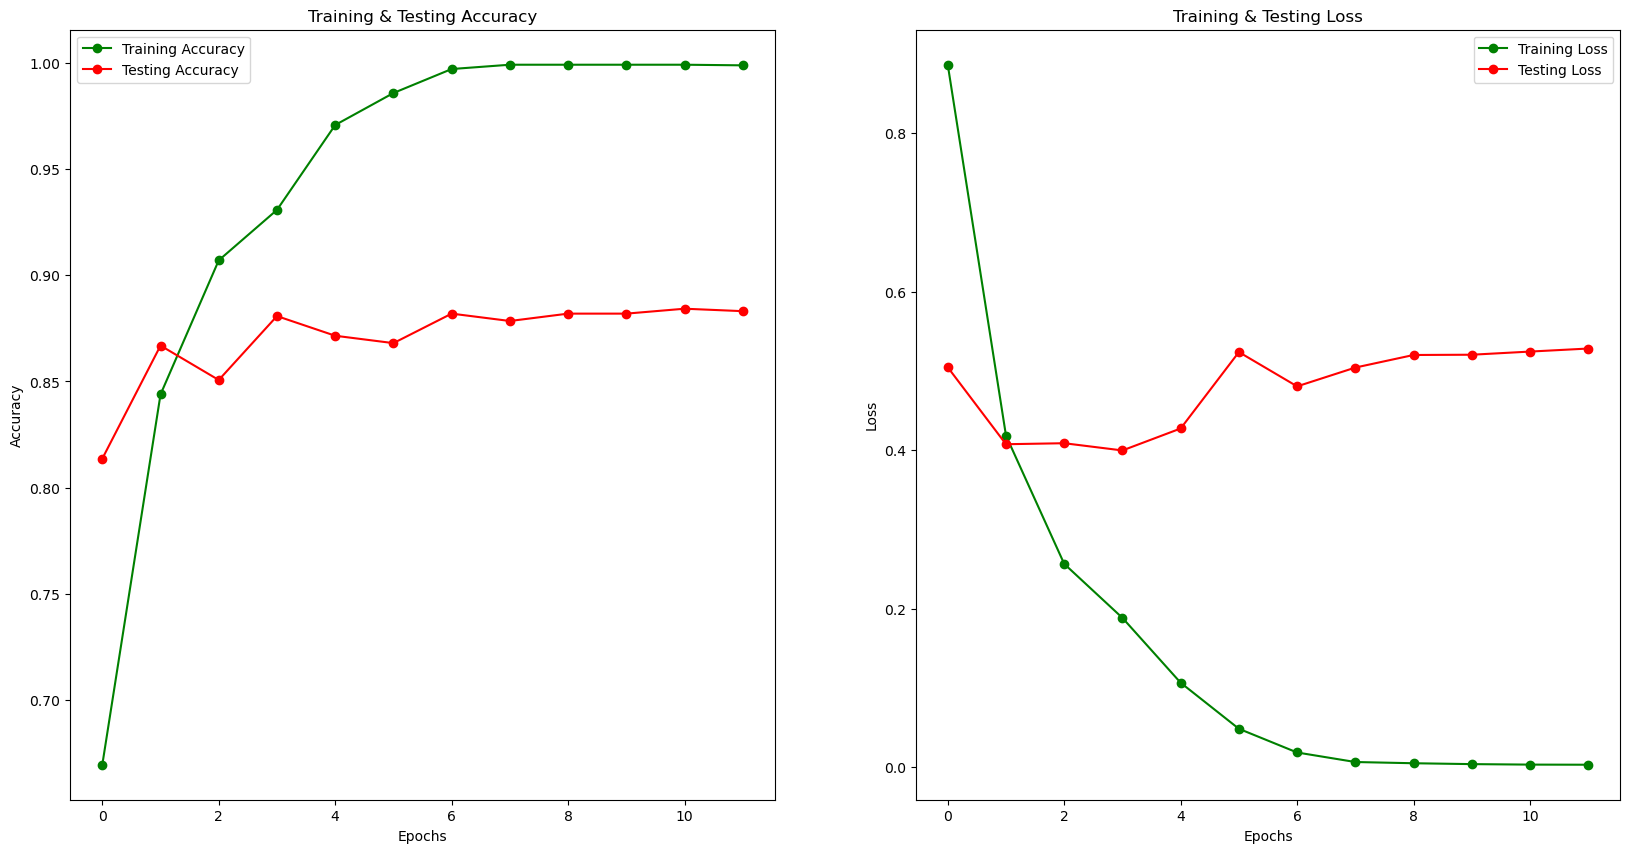

In [18]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [25]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis=1)

27/27 [==============================] - 2s 75ms/step


In [26]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [27]:
print(classification_report(y_test_inv, predictions, target_names = labels))

              precision    recall  f1-score   support

   dandelion       0.89      0.92      0.91       210
       daisy       0.91      0.89      0.90       153
       tulip       0.87      0.85      0.86       197
   sunflower       0.91      0.91      0.91       147
        rose       0.84      0.84      0.84       157

    accuracy                           0.88       864
   macro avg       0.88      0.88      0.88       864
weighted avg       0.88      0.88      0.88       864



In [28]:
cm = confusion_matrix(y_test_inv,predictions)
cm

array([[194,   5,   4,   6,   1],
       [  8, 136,   5,   2,   2],
       [  5,   4, 167,   2,  19],
       [  4,   3,   2, 134,   4],
       [  6,   1,  15,   3, 132]])

In [30]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

<AxesSubplot:>

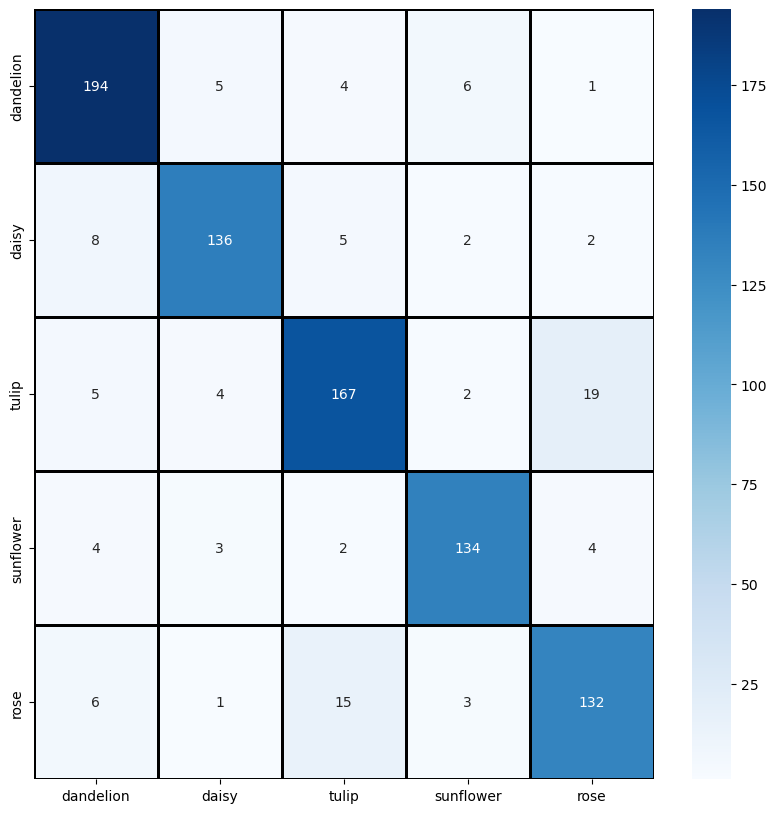

In [31]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [32]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break


CORRECTLY CLASSIFIED FLOWER IMAGES

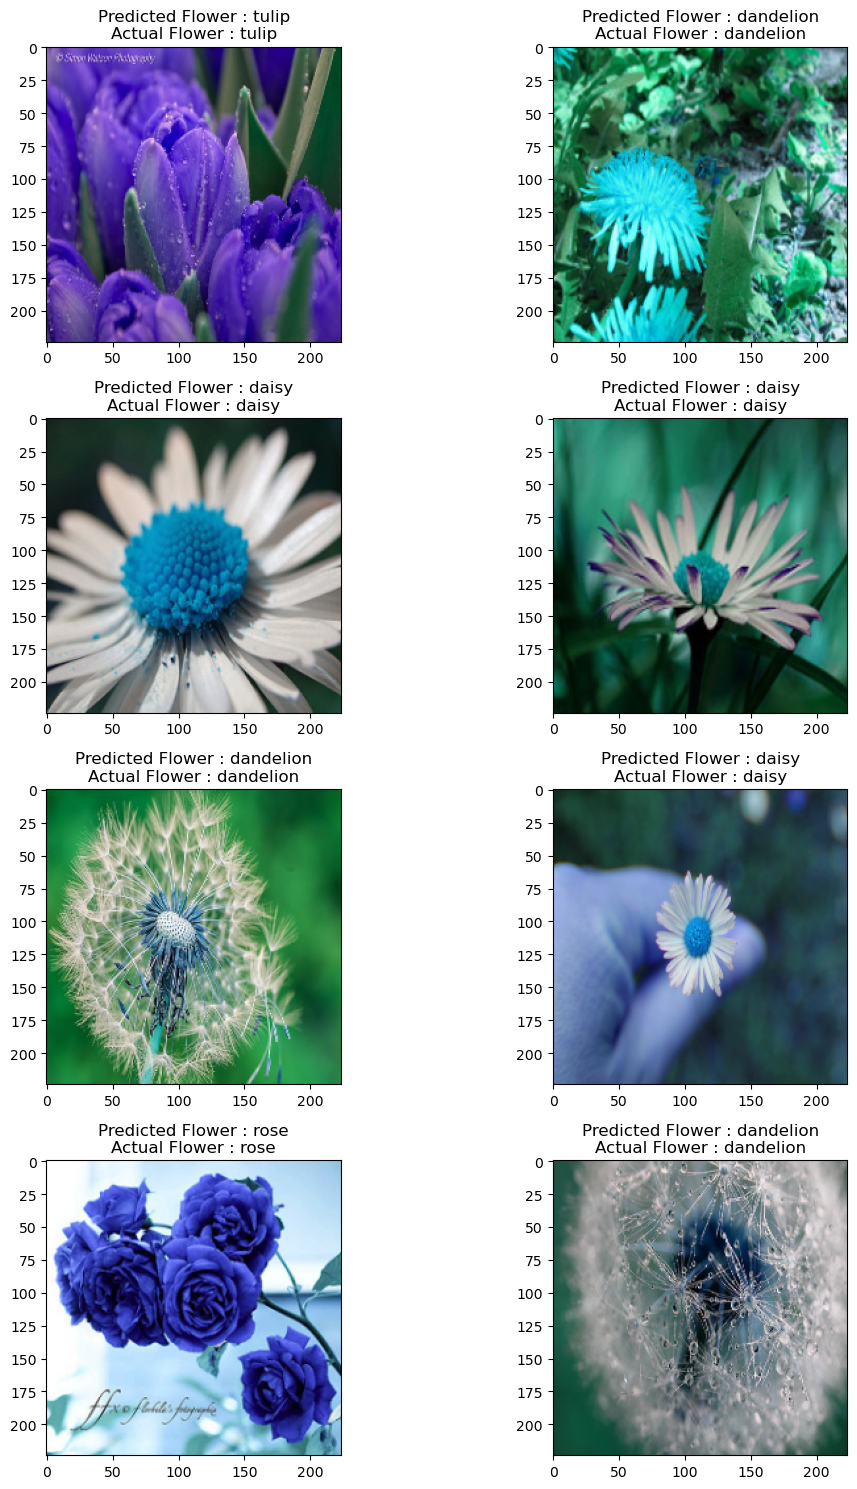

In [33]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

INCORRECTLY CLASSIFIED FLOWER IMAGES

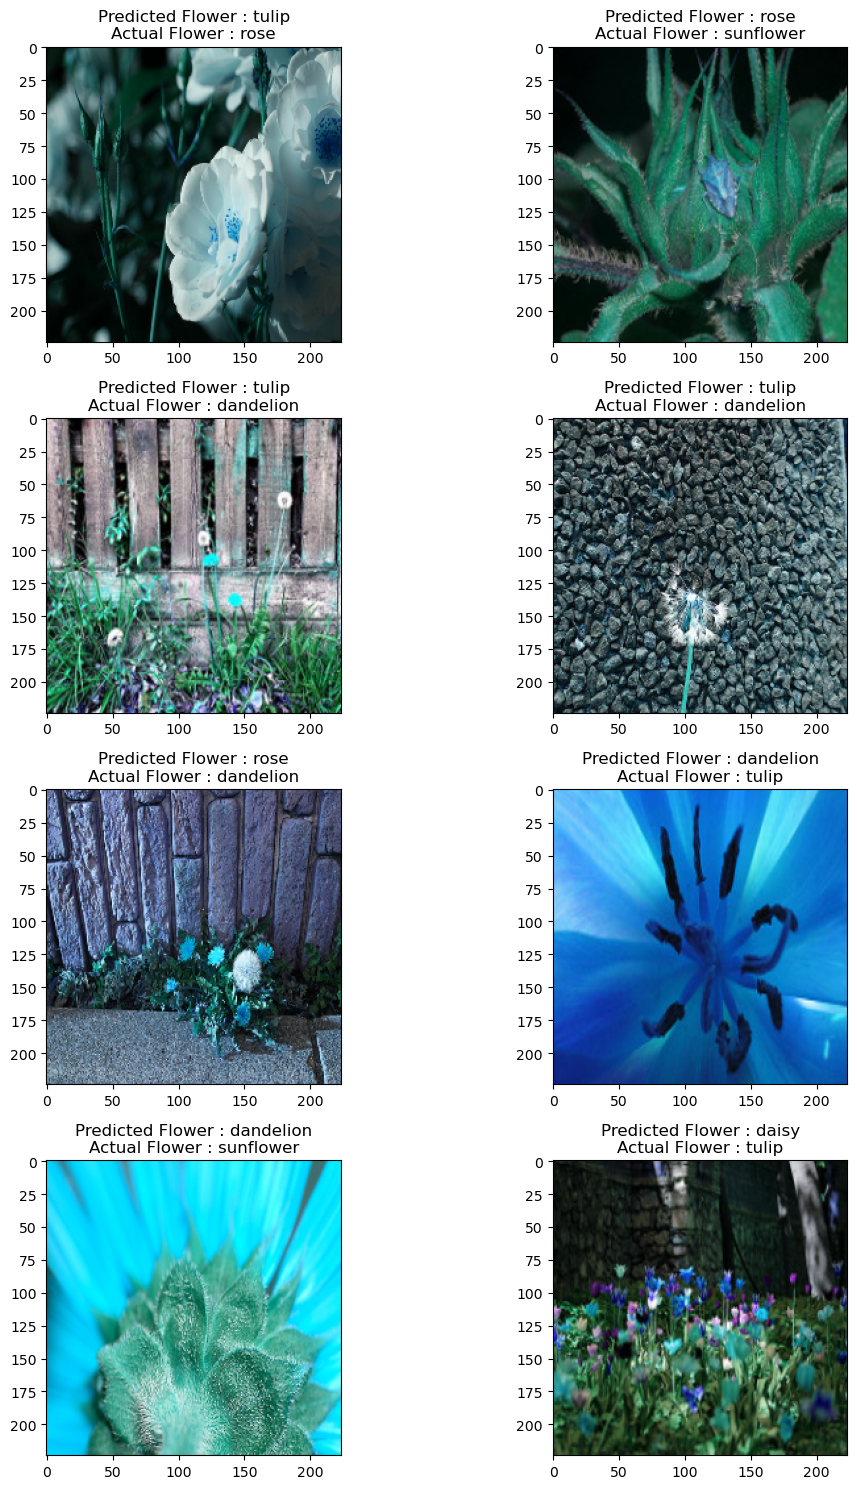

In [34]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1